In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import os
import time
import sys

In [3]:
data = pd.read_csv(f"rule-vetting/data/tbi_pecarn/raw/data_no_imputation.csv")
data.head()

,GCSTotal,AgeinYears,AgeInMonth,ClavNeck_0,ClavNeck_1,ClavNeck_92,ClavTem_0,ClavTem_1,ClavTem_92,Hema_0,...,Race_90,SFxPalp_0,SFxPalp_1,SFxPalp_2,SFxBasHem_0,SFxBasHem_1,SFxBasHem_92,AgeTwoPlus_1,AgeTwoPlus_2,outcome
0,15,16,197,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0.0
1,15,5,64,0,0,1,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0.0
2,15,1,13,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0.0
3,15,3,46,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0.0
4,15,4,51,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0.0


In [4]:
# 1289 entries have GCS Total scores that do no match their associated metrics. 
    # Of these, only 48 have any GCS scores provided at all and only 12 have a critical outcome

gcs_scores = [(x, data[x]) for x in data.columns if 'GCS' in x and 'GCSGroup' not in x and x != 'GCSTotal']

new_data = pd.DataFrame()

for i in range(len(gcs_scores)):
    new_data[gcs_scores[i][0]] = data[gcs_scores[i][0]] * int(gcs_scores[i][0].split('_')[1])

print(len(data[[x for x in data.columns if 'GCS' in x]][data['GCSTotal'] != new_data.sum(1)]))
print(len(data[[x for x in data.columns if 'GCS' in x]][data['GCSTotal'] != new_data.sum(1)][new_data.sum(1) > 0]))
print(len(data[[x for x in data.columns if 'GCS' in x]][data['GCSTotal'] != new_data.sum(1)][data['outcome'] == 1]))

data['GCSTotal'] = new_data.sum(1)

1289
48
12


<ipython-input-4-814a7751f157>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(data[[x for x in data.columns if 'GCS' in x]][data['GCSTotal'] != new_data.sum(1)][new_data.sum(1) > 0]))
<ipython-input-4-814a7751f157>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(data[[x for x in data.columns if 'GCS' in x]][data['GCSTotal'] != new_data.sum(1)][data['outcome'] == 1]))


In [5]:
# Omitting variables
    # SFx/Font Bulg = Dr. Liu would already send to CT (not needed)
    # Race, Ethnicity, Gender = beyond scope of this work
    # AgeinYears = redundant w/ AgeinMonths
    # GCSGroup_2 = always True
    # InjMech = captured in High_Impact_InjSev
    # Dizzy = large number of values missing
    # OSI = obvious call?
    
variables_to_omit = [x for x in list(data.columns) if 'SFx' in x or 'FontBulg' in x or 'Race' in x or x == 'AgeinYears'
                        or 'Ethnicity' in x or 'InjuryMech' in x or 'Gender' in x or 'OSI' in x or 'Dizzy' in x]
data = data.drop(variables_to_omit, axis = 1)
data = data[data['GCSTotal'] >= 14]
outcome = data['outcome']

In [6]:
# Scaling nonbinary columns
    # Note: This may reduce interpretability and should probably not be used during actual modeling
nonbin_cols = [x for x in list(data.columns) if data[x].max() not in [0, 1] or data[x].min() not in [0,1]]
for x in nonbin_cols:
    data[x] = data[x]/data[x].max()

In [7]:
def model_stats (data):
    total_patients = len(data)
    total_critical = round(sum(data['Outcome']))
    correct_recs = len(data[(data['Outcome'] == data['Prediction'])])
    correct_CTs = len(data[(data['Outcome'] == data['Prediction']) & (data['Outcome'] == 1)])
    false_negatives = len(data[(data['Outcome'] != data['Prediction']) & (data['Outcome'] == 1)])
    false_positives = len(data[(data['Outcome'] != data['Prediction']) & (data['Outcome'] == 0)])
    total_CTs = sum(data['Prediction'])
    return {'Total Patients': total_patients, 'Total Critical Outcomes': total_critical,
                'Correct Recommendations': correct_recs, 'Total Recommended CTs': total_CTs, 
                'Correct CTs': correct_CTs, 'Missed CTs': false_negatives,
                'Accuracy': correct_recs / total_patients, 'Sensitivity': correct_CTs / (correct_CTs + false_negatives),
                'NPV': (correct_recs - correct_CTs) / (correct_recs - correct_CTs + false_negatives),
                'Specificity': (correct_recs - correct_CTs) / (correct_recs - correct_CTs + total_CTs - correct_CTs)}

def model_check(data, outcome, intercept, coef, cols, threshold = 0.005):
    rhs = np.exp(model.intercept_ + sum([coef[i] * data[cols[i]] 
                                    for i in range(len(cols))]))

    prob = rhs/(1 + rhs)

    check = data.copy()
    
    check['Prediction']= np.where(prob <= threshold, 0, 1)
#     data['Prediction'] = prob
    check['Outcome'] = outcome
    
    return(check, model_stats(check))

In [8]:
# Splitting up the data into easily interpretable categories for mixing and matching in models
demographics = ['AgeInMonth', 'AgeinYears', 'AgeTwoPlus', 'Gender', 'Ethnicity', 'Race']
hospitalStats = ['PatNum', 'EmplType', 'Certification']
symptoms = ['InjuryMech', 'High_impact_InjSev', 'Amnesia_verb', 'LocLen', 'Seiz', 'SeizOccur', 'SeizLen', 'ActNorm',
                'HA_verb', 'HASeverity', 'HAStart', 'Vomit', 'VomitNbr', 'VomitStart', 'VomitLast', 'Dizzy', 'GCSEye',
                'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS', 'AMSAgitated', 'AMSSleep', 'AMSSlow', 
                'AMSRepeat', 'AMSOth', 'SFxPalp', 'SFxPalpDepress', 'FontBulg', 'SFxBas', 'SFxBasHem', 'SFxBasOto',
                'SFxBasPer', 'SFxBasRet', 'SFxBasRhi', 'Hema', 'HemaLoc', 'HemaSize', 'Clav', 'ClavFace', 'ClavNeck',
                'ClavFro', 'ClavOcc', 'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 
                'NeuroDReflex', 'NeuroDOth', 'OSI', 'OSIExtremity', 'OSICut', 'OSICspine', 'OSIFlank', 'OSIAbdomen',
                'OSIPelvis', 'OSIOth', 'Drugs', 'LOCSeparate']
hospitalActions = ['Intubated', 'Paralyzed', 'Sedated', 'CTForm1', 'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx',
                       'IndHA', 'IndHema', 'IndLOC', 'IndMech', 'IndNeuroD', 'IndRqstMD', 'IndRqstParent',
                       'IndRqstTrauma', 'IndSeiz', 'IndVomit', 'IndXraySFx', 'IndOth', 'CTSed', 'CTSedAgitate',
                       'CTSedAge', 'CTSedRqst', 'CTSedOth', 'Observed', 'EDDisposition', 'CTDone', 'EDCT']
outcomes = ['PosCT', 'Finding1', 'Finding2', 'Finding3', 'Finding4', 'Finding5', 'Finding6', 'Finding7',
                'Finding8', 'Finding9', 'Finding10', 'Finding11', 'Finding12', 'Finding13', 'Finding14', 'Finding20', 
                'Finding21', 'Finding22', 'Finding23', 'DeathTBI', 'HospHead', 'HospHeadPosCT', 'Intub24Head', 
                'Neurosurgery', 'PosIntFinal']

In [9]:
# Subset columns, keeping only demographics, symptoms, and the outcome
subset = []
subset.extend(demographics)
subset.extend(symptoms)
subset.extend(['outcome'])
binary_subset = sorted(list(set([y for x in subset for y in list(data.columns) if x.lower() in y.lower()])))
subset_mapping = {x:sorted(list(set([y for y in list(data.columns) if x.lower() == y.rsplit('_',1)[0].lower()]))) 
                  for x in subset}
data = data[binary_subset]

print(f"Total samples: {len(outcome)}\nPercent of patients with ciTBIs: {round(100*sum(outcome)/len(outcome), 2)}%")

Total samples: 41124
Percent of patients with ciTBIs: 0.89%


In [10]:
# 90 = other
# 91 = pre-verbal (cannot communicate)
# 92 = not applicable
# 0 not used for AgeTwoPlus

variables = []
frequency = []

for x in list(subset_mapping.keys()):
    if subset_mapping[x] != []:
        cols = [col for col in subset_mapping[x] if '0' not in col and '92' not in col]
        variables.append(x)
        frequency.append(round(data[cols].eq(1).any(1).mean() * 100, 4))
    
pd.DataFrame({'Variable': variables, 'Frequency': frequency})

,Variable,Frequency
0,AgeInMonth,0.3550
1,AgeTwoPlus,100.0000
2,High_impact_InjSev,99.2705
3,Amnesia_verb,44.0692
4,LocLen,9.4811
5,Seiz,1.1794
6,SeizOccur,1.0578
7,SeizLen,1.0018
8,ActNorm,78.3338
9,HA_verb,61.8665


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import numpy as np
np.random.seed(1)

# Create random training and test splits
n = data.shape[0]
train_size = round(0.8 * n)
test_size = n - train_size
train_indices = np.random.choice(n, train_size, replace = False)
test_indices = list(set(np.arange(n)) - set(train_indices))
train = data.iloc[train_indices]
test = data.iloc[test_indices]
y_train = train.outcome
y_test = test.outcome
train = train.drop(['outcome'], axis = 1)
test = test.drop(['outcome'], axis = 1)
data = data.drop(['outcome'], axis = 1)

In [11]:
# Feature Selection
    # Demonstrates that only small accuracy gained by more iteration, but significance of variables unchanged
low_iter_model = LogisticRegression(random_state=0, class_weight= 'balanced', max_iter = 100).fit(train, y_train)
high_iter_model = LogisticRegression(random_state=0, class_weight= 'balanced', max_iter = 1000).fit(train, y_train)

low_iter_acc = low_iter_model.score(test, y_test)
high_iter_acc = high_iter_model.score(test, y_test)

print(f'low_acc {round((low_iter_acc - high_iter_acc)/high_iter_acc * 100, 4)}% higher than high_acc')

for x in [0.25, 0.5, 0.75, 1, 1.25]:
    selector = SelectFromModel(estimator= low_iter_model, 
                                   threshold = f'{x}*mean').fit(train, y_train)

    low_iter = [list(data.columns)[i] for i in range(len(data.columns)) if selector.get_support()[i] == True 
                and selector.estimator_.coef_[0][i] > 0]

    selector = SelectFromModel(estimator=high_iter_model, 
                                   threshold = f'{x}*mean').fit(train, y_train)

    high_iter = [list(data.columns)[i] for i in range(len(data.columns)) if selector.get_support()[i] == True 
                and selector.estimator_.coef_[0][i] > 0]

    low_iter_freq = round(sum([low_iter[i] in high_iter for i in range(len(low_iter))])/len(low_iter), 3) * 100
    high_iter_freq = round(sum([high_iter[i] in low_iter for i in range(len(high_iter))])/len(high_iter), 3) * 100

    print(f'{low_iter_freq}% of low_iter in high_iter \n{high_iter_freq}% of high_iter in low_iter at {x}') 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-4606ba4ea049>", line 3, in <module>
    low_iter_model = LogisticRegression(random_state=0, class_weight= 'balanced', max_iter = 100).fit(train, y_train)
  File "c:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\users\bowen\appdata\local\programs\python\python39\lib

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Feature Selection
    # Demonstrates higher weighting -> shifts in level of importance of variables, but not variables themselves
balanced_weight_model = LogisticRegression(random_state=0, class_weight= 'balanced', max_iter = 100).fit(train, y_train)
high_weight_model = LogisticRegression(random_state=0, class_weight= {0:1, 1:500}, max_iter = 100).fit(train, y_train)

low_weight_acc = balanced_weight_model.score(test, y_test)
high_weight_acc = high_weight_model.score(test, y_test)

print(f'balanced_weight_acc {round((low_weight_acc - high_weight_acc)/high_weight_acc * 100, 4)}% higher than high_weight_acc')

for x in [0.25, 0.5, 0.75, 1, 1.25]:
    selector = SelectFromModel(estimator= balanced_weight_model, 
                                   threshold = f'{x}*mean').fit(data, outcome)

    balanced_weight = [list(data.columns)[i] for i in range(len(data.columns)) if selector.get_support()[i] == True 
                and selector.estimator_.coef_[0][i] > 0]

    selector = SelectFromModel(estimator=high_weight_model, 
                                   threshold = f'{x}*mean').fit(data, outcome)

    high_weight = [list(data.columns)[i] for i in range(len(data.columns)) if selector.get_support()[i] == True 
                and selector.estimator_.coef_[0][i] > 0]

    balanced_weight_freq = round(sum([balanced_weight[i] in high_weight for i in range(len(balanced_weight))])/len(balanced_weight), 3) * 100
    high_weight_freq = round(sum([high_weight[i] in balanced_weight for i in range(len(high_weight))])/len(high_weight), 3) * 100

    print(f'{balanced_weight_freq}% of balanced_weight in high_weight \n{high_weight_freq}% of high_weight in balanced_weight at {x}') 

In [45]:
# Final feature selection: high weight, low iteration, iterative, only positive correlation
    # Uses full data set, is this a problem?
    # Probably the best feature selection metric we have currently
important_variables_iter = list(data.columns)
    
while True:
    print(len(important_variables_iter))
    
    selector = SelectFromModel(estimator= LogisticRegression(random_state=0, max_iter = 1000),
                                   threshold = f'0.75*mean').fit(data[important_variables_iter], outcome)

    important_variables_iter = [list(data[important_variables_iter].columns)[i] 
                           for i in range(len(data[important_variables_iter].columns)) 
                           if selector.get_support()[i] == True]
    
    if len(important_variables_iter) <= 30:
        break
        
print(f'{len(important_variables_iter)} chosen: {important_variables_iter}')

129
58
32
19 chosen: ['AMSAgitated_1', 'AMSRepeat_1', 'AMSSleep_1', 'ActNorm_0', 'ActNorm_1', 'ClavOcc_1', 'HASeverity_1', 'HAStart_3', 'HA_verb_0', 'HemaLoc_3', 'HemaSize_3', 'High_impact_InjSev_1', 'LOCSeparate_0', 'SeizLen_4', 'SeizOccur_2', 'VomitLast_3', 'VomitStart_2', 'VomitStart_3', 'VomitStart_4']


In [46]:
# Note: NeuroDOth_0 = 1 means NeuroD = 1 and it is one or more of Sensory, Cranial, or Reflex

important_variables = list(set([x.rsplit('_',1)[0] for x in important_variables_iter]))
important_variable_scores = [x for x in list(data.columns) if x.rsplit('_',1)[0] in important_variables]
min_variable_categories = sorted([[x for x in important_variable_scores if y in x][0] for y in important_variables])
usable_variable_categories = sorted([x for x in important_variable_scores if x not in min_variable_categories])

model = LogisticRegression(random_state=0, max_iter = 1000)\
        .fit(train[usable_variable_categories], y_train)

official_model = model
official_usable_variable_categories = usable_variable_categories

acc = model.score(test[usable_variable_categories], y_test)

print(acc)

# print(model.coef_)
print(list(train[usable_variable_categories].columns))

0.9908814589665653
['AMSAgitated_1', 'AMSAgitated_92', 'AMSRepeat_1', 'AMSRepeat_92', 'AMSSleep_1', 'AMSSleep_92', 'ActNorm_1', 'ClavOcc_1', 'ClavOcc_92', 'HASeverity_2', 'HASeverity_3', 'HASeverity_92', 'HAStart_2', 'HAStart_3', 'HAStart_4', 'HAStart_92', 'HA_verb_1', 'HA_verb_91', 'HemaLoc_2', 'HemaLoc_3', 'HemaLoc_92', 'HemaSize_2', 'HemaSize_3', 'HemaSize_92', 'High_impact_InjSev_2', 'High_impact_InjSev_3', 'LOCSeparate_1', 'LOCSeparate_2', 'SeizLen_2', 'SeizLen_3', 'SeizLen_4', 'SeizLen_92', 'SeizOccur_2', 'SeizOccur_3', 'SeizOccur_92', 'VomitLast_2', 'VomitLast_3', 'VomitLast_92', 'VomitStart_2', 'VomitStart_3', 'VomitStart_4', 'VomitStart_92']


In [47]:
reference = (important_variables, model_check(test, y_test, model.intercept_, model.coef_[0], usable_variable_categories)[1])

In [48]:
check, stats = model_check(test, y_test, model.intercept_, model.coef_[0], usable_variable_categories)
print(stats)

{'Total Patients': 8225, 'Total Critical Outcomes': 74, 'Correct Recommendations': 5960, 'Total Recommended CTs': 2321, 'Correct CTs': 65, 'Missed CTs': 9, 'Accuracy': 0.7246200607902735, 'Sensitivity': 0.8783783783783784, 'NPV': 0.9984756097560976, 'Specificity': 0.7232241442767758}


In [ ]:
f = plt.figure(figsize=(19, 15))
data[usable_variable_categories].corr()
plt.matshow(data[usable_variable_categories].corr(), fignum=f.number)
plt.xticks(range(data[usable_variable_categories].select_dtypes(['number']).shape[1]), data[usable_variable_categories].select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(data[usable_variable_categories].select_dtypes(['number']).shape[1]), data[usable_variable_categories].select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14);

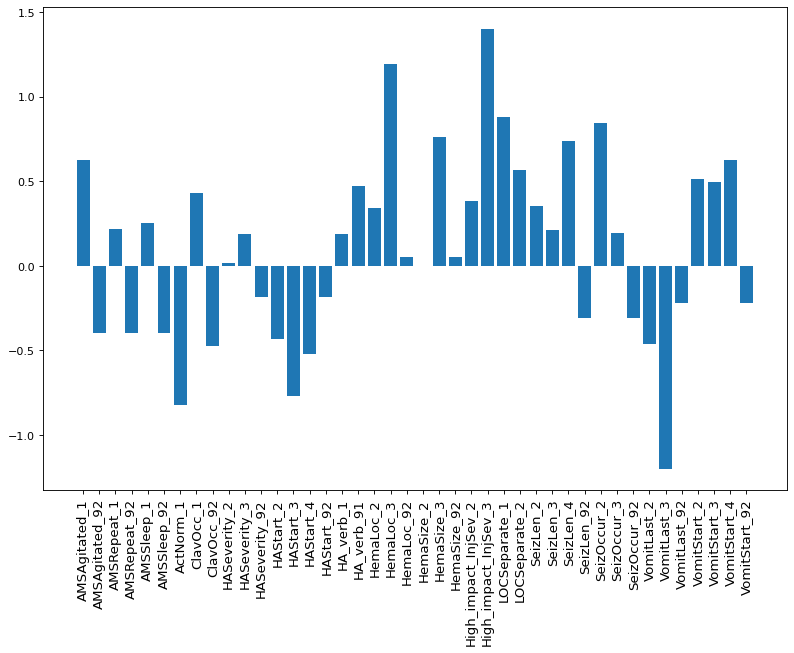

In [44]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

height = list(official_model.coef_[0])
bars = official_usable_variable_categories
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90, size = 12)

# Show graphic
plt.savefig('logbar.png')
plt.show()


In [ ]:
predictors = pd.DataFrame({'Predictor': [x.rsplit('_',1)[0] for x in important_variable_scores], 
                               'Categories': important_variable_scores})
predictors.to_csv('rule-vetting/data/predictors.csv', index=False)

In [ ]:
import yaml
saved_model = {x:{y: float(model.coef_[0][usable_variable_categories.index(y)])
                  if y in usable_variable_categories else 0
                  for y in important_variable_scores if x in y} for x in important_variables}
saved_model['Intercept'] = float(model.intercept_[0])

saved_model = dict(saved_model)

with open('model.yml', 'w') as outfile:
    yaml.dump(saved_model, outfile)

In [ ]:
print(yaml.dump(saved_model))

In [ ]:
# Testing different filters

for x in [0.25, 0.5, 0.75, 1, 1.25, 1.5]:
    important_variables_iter = list(data.columns)
    prev_length = len(important_variables_iter)
    
    while True:
        selector = SelectFromModel(estimator= LogisticRegression(random_state=0, max_iter = 1000),
                                       threshold = f'{x}*mean').fit(data[important_variables_iter], outcome)

        important_variables_iter = [list(data[important_variables_iter].columns)[i] 
                               for i in range(len(data[important_variables_iter].columns)) 
                               if selector.get_support()[i] == True]

        if len(important_variables_iter) <= 30:
            converged = True
            break
        elif prev_length == len(important_variables_iter):
            converged = False
            break
        else:
            prev_length = len(important_variables_iter)

    important_variables = list(set([x.rsplit('_',1)[0] for x in important_variables_iter]))
    important_variable_scores = [x for x in list(data.columns) if x.rsplit('_',1)[0] in important_variables]
    min_variable_categories = sorted([[x for x in important_variable_scores if y in x][0] for y in important_variables])
    usable_variable_categories = sorted([x for x in important_variable_scores if x not in min_variable_categories])

    model = LogisticRegression(random_state=0, max_iter = 1000)\
            .fit(train[usable_variable_categories], y_train)
    
    check, stats = model_check(test, y_test, model.intercept_, model.coef_[0], usable_variable_categories)
    changes = {f'Changed {x}': reference[1][x] - stats[x] for x in reference[1].keys()}
    
    print({'Mean Filter': x, 'Converged': converged, 'Total Predictors': len(important_variables),
           'New Variables': set(important_variables) - set(reference[0]),
           'Missed Variables': set(reference[0]) - set(important_variables), 
           'Stat Changes': changes})

In [ ]:
complete_data = pd.read_csv(f"rule-vetting/data/tbi_pecarn/raw/data_no_imputation.csv")
complete_data = complete_data[complete_data['GCSTotal'] >= 14]
complete_outcome = complete_data.outcome

n = complete_data.shape[0]
train_size = round(0.8 * n)
test_size = n - train_size
train_indices = np.random.choice(n, train_size, replace = False)
test_indices = list(set(np.arange(n)) - set(train_indices))
complete_train = complete_data.iloc[train_indices]
complete_test = complete_data.iloc[test_indices]
complete_y_train = complete_train.outcome
complete_y_test = complete_test.outcome
complete_train = complete_train.drop(['outcome'], axis = 1)
complete_test = complete_test.drop(['outcome'], axis = 1)
complete_data = complete_data.drop(['outcome'], axis = 1)

for x in ['SFx', 'OSI', 'InjuryMech', 'Dizzy']:
    important_variables_iter = list(data.columns)
    important_variables_iter.extend([col for col in list(complete_data) if 'SFx' in col])
    prev_length = len(important_variables_iter)
    
    while True:
        selector = SelectFromModel(estimator= LogisticRegression(random_state=0, max_iter = 1000),
                                       threshold = f'0.75*mean').fit(complete_data[important_variables_iter], 
                                                                     complete_outcome)

        important_variables_iter = [list(complete_data[important_variables_iter].columns)[i] 
                               for i in range(len(complete_data[important_variables_iter].columns)) 
                               if selector.get_support()[i] == True]

        if len(important_variables_iter) <= 30:
            converged = True
            break
        elif prev_length == len(important_variables_iter):
            converged = False
            break
        else:
            prev_length = len(important_variables_iter)

    important_variables = list(set([x.rsplit('_',1)[0] for x in important_variables_iter]))
    important_variable_scores = [x for x in list(complete_data.columns) if x.rsplit('_',1)[0] in important_variables]
    min_variable_categories = sorted([[x for x in important_variable_scores if y in x][0] for y in important_variables])
    usable_variable_categories = sorted([x for x in important_variable_scores if x not in min_variable_categories])

    model = LogisticRegression(random_state=0, max_iter = 1000)\
            .fit(complete_train[usable_variable_categories], complete_y_train)
    
    check, stats = model_check(complete_test, complete_y_test, model.intercept_, model.coef_[0], 
                               usable_variable_categories)
    changes = {f'Changed {x}': reference[1][x] - stats[x] for x in reference[1].keys()}
    
    print({'Added Group': x, 'Converged': converged, 'Total Predictors': len(important_variables),
           'New Variables': set(important_variables) - set(reference[0]),
           'Missed Variables': set(reference[0]) - set(important_variables), 
           'Stat Changes': changes})

In [25]:
# Testing different filters

changes = {x: 0 for x in reference[1].keys()}

for i in range(25):
    new_data = pd.read_csv(f"rule-vetting/data/tbi_pecarn/raw/data_no_imputation.csv").sample(n = len(data), replace = True)
    new_data = new_data[new_data['GCSTotal'] >= 14]
    new_outcome = new_data.outcome

    new_train = new_data.iloc[train_indices]
    new_test = new_data.iloc[test_indices]
    new_y_train = new_train.outcome
    new_y_test = new_test.outcome
    new_train = new_train.drop(['outcome'], axis = 1)
    new_test = new_test.drop(['outcome'], axis = 1)
    new_data = new_data[[x for x in list(data.columns)]]
    
    check, stats = model_check(new_test, new_y_test, model.intercept_, official_model.coef_[0], 
                               official_usable_variable_categories)
    changes = {x: changes[x] + reference[1][x] - stats[x] for x in reference[1].keys()}
    
changes = {x: changes[x]/25 for x in reference[1].keys()}
print(changes)

{'Total Patients': 0.0, 'Total Critical Outcomes': 1.56, 'Correct Recommendations': -31.6, 'Total Recommended CTs': 34.2, 'Correct CTs': 2.08, 'Missed CTs': -0.52, 'Accuracy': -0.0038419452887538297, 'Sensitivity': 0.01001840256623289, 'NPV': 7.862958851325264e-05, 'Specificity': -0.0039940025046248185}


Dr. Liu singled out the following variables as strong signals of a ciTBI:
- Severe headache
- loss of consciousness (yes/no & length)
- dizziness
- acting abnormal
- vomiting
- GCSTotal
- basilar skull fracture
- Palpable skull fracture

That said, we didn't talk about most factors collected in the dataset.
These include age, drugs, seizures, injury mechanism, other conditions, etc.
